In [1]:
%reload_ext autoreload
%autoreload 2

from magnetism import *
import matplotlib.pyplot as plt
import numpy as np
import functools
import itertools
import pandas as pd
from IPython.display import display
from timeit import default_timer as timer
import warnings
from concurrent.futures import ProcessPoolExecutor

warnings.filterwarnings("ignore")

## Assignment 2: Magnetism
### _Kevin Vonk, s1706896, feb-mar 2020_

## Part 1

#### 1a)
Starting with the derivative of F to B,

$$
\begin{aligned}
    \frac{\partial F}{\partial B} &= -\frac{\partial}{\partial B} \frac{1}{\beta} \ln{Z} \\
    &= -\frac{1}{Z\beta} Z * -\beta \frac{\partial E}{\partial B} \\
    &= -\frac{1}{Z} \sum_{i=1}^K M(S_i)e^{-\beta E},
\end{aligned}
$$

which proves that

$$
\langle M\rangle = -\frac{\partial F}{\partial B}.
$$

#### 1b)
Starting with the derivative of the expectation value of M to B,

$$
\begin{aligned}
    \frac{\partial \langle M \rangle}{\partial B} &= \frac{\partial}{\partial B} \left(\frac{1}{Z}\right) \sum Me^{-\beta E} + \frac{1}{Z} \frac{\partial}{\partial B} \sum Me^{-\beta E} \\
    &= -\beta M \frac{1}{Z^2} \sum Me^{-\beta E} e^{-\beta E} + \frac{1}{Z} \sum Me^{-\beta E} \beta M \\
    &= \beta \left( \langle M^2\rangle - \langle M \rangle^2 \right),
\end{aligned}
$$

which is exactly the expected form.

#### 2)
In the Ising model with $N$ spins, there will be a total $2^N$ spin configurations. There are two options (spin-up and spin-down), and N elements which can take on these two options. If a computer can calculate $10^9$ configurations per second, we will get execution times as shown in the table below.

| $N$ | $L$ | Execution time (s) |
| --- | --- | --- |
| $5$ | $25$ | $0,034$ |
| $10$ | $100$ | $1,27*10^{21}$ |

From this table we can see that brute-forcing every possibility is simply not an option. Humanity will not be alive long enough to ever see the answer using this method.

#### 3a)
The transition probability $T$ is symmetric, since the probability for flipping any spin is constant. Since the index of the spin to flip is chosen randomly, and thus not dependent on energy or position, the probability of picking any index $i$ is as equal as picking index $j$. Furthermore, the probability is constant over the moves in the system. That means that the probability of picking index $i$ will remain unchanged. Combining this, we can say that $T$ is symmetric.

#### 3b)
The detailed balance is defined as
$$
P(S)W(S \rightarrow S') = P(S')W(S' \rightarrow S),
$$

where $W$ is defined as

$$
W(S \rightarrow S') = T(S \rightarrow S')A(S \rightarrow S').
$$

There are two values for A. Starting with $A = 1$, the detailed balance becomes

$$
P(S)T(S \rightarrow S') = P(S')T(S' \rightarrow S),
$$

which, since $T$ is symmetric, becomes

$$
P(S) = P(S'),
$$

which is what we would expect. Now, for $A = \frac{P(S')}{P(S)}$, the detailed balance becomes

$$
P(S)\frac{P(S')}{P(S)}T(S \rightarrow S') = P(S')\frac{P(S')}{P(S)}T(S' \rightarrow S).
$$

Again, using the fact that $T$ is symmetric and dropping the $\frac{P(S')}{P(S)}$ term on both sides, we obtain,

$$
P(S) = P(S'),
$$

which again is expected.

#### 3c)
Whenever a move is rejected, we must still add the current value of $M(S)$ to the average magnetisation, because we have taken a step in our system and are thus residing in a new state. The fact that nothing has changed in the system doesn't matter, this new state is still different than the previous.

#### 4a)
We are going to work with the energy difference $\Delta E$.

$$
\Delta E = E(S') - E(S) = -B\left(\sum s'_i - \sum s_i \right) = \mp 2B = 
\begin{cases}
    -2B & \text{for} \; -1 \; \rightarrow \; +1 \\
    2B & \text{for} \; +1 \; \rightarrow \; -1
\end{cases}
$$

#### 4b)
$M(S)$ is the sum of all individual spins, $\sum s_i$. If we flip a spin, this introduces a change in $M(S)$ as follows,

$$
M(S') = M(S) - \frac{\Delta E}{B} = 
\begin{cases}
    M(S) + 2 & \text{for} \; -1 \; \rightarrow \; +1 \\
    M(S) - 2 & \text{for} \; +1 \; \rightarrow \; -1
\end{cases}
$$

#### 4c)
We needn't store all the spin configurations over the whole sequence. We only need to start with an initial state and calculate the relevant quantities in that state. Then, we can say that the initial state is the current state. For every iteration we can flip a spin in the current state, and update the relevant quantities using the deltas explored above. As long as we keep the current state "up-to-date", we shouldn't need every step in the sequence.

#### 5a)

The result of three Monte Carlo simulations are found in the plot below. The behaviour for each run is very similar. We first see a convergence towards the exact result. After an amount of steps have passed, we see a random walk around the exact result.

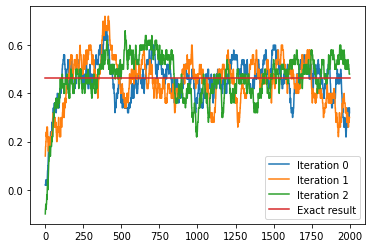

In [2]:
N = 2000

for i in range(3):
    lattice = Lattice(L = 10, B = 0.5)
    solver = Solver(lattice)

    M = []
    for lat in solver.iterate(N):
        M.append(lat.M)

    plt.plot(range(N), np.array(M)/100, label=f"Iteration {i}")

plt.plot((0, N), [np.tanh(0.5) for _ in range(2)], label=f"Exact result")
plt.legend()

#### 5b)
In the case of the figure above, we could say that $\kappa \approx 200$ steps. For larger $\left| B \right|$ this value will be larger, since it takes more steps of changing a single spin to reach a higher exact value.

#### 5c)
We will do 100 measurements with $L = 10$, $B = 0,5$, $N = 2000$. The computed magnetisation and standard deviation can be found below the code block.

In [3]:
N = 2000
iter = 100
L = 10
exp = []
m2 = []

for _ in range(iter):
    lattice = Lattice(L = L, B = 0.5)
    solver = Solver(lattice)

    M = []
    for lat in solver.iterate(N):
        M.append(lat.M)

    m = np.array(M[200:]) / (L**2)
    exp.append(1/len(m) * np.sum(m))
    m2.append(1/len(m) * np.sum(m**2))

exp = np.array(exp)
m2 = np.array(m2)

print(f"Computed: m = {np.mean(exp)} ± {np.std(exp)} (standard deviation)")
print(f"   Exact: m = {np.tanh(0.5)}")

Computed: m = 0.46275011111111114 ± 0.024855925914640028 (standard deviation)
   Exact: m = 0.46211715726000974


The standard deviation seems a reasonable expression for the error, with the exact magnetisation falling in the domain of the computed magnetisation and the error about two-thirds of the runs (as is expected from the standard deviation).

#### 5d)
The computed error using this method is given below.

In [4]:
dm = np.sqrt((m2 - exp**2)/(len(m)-1))

print(f"Computed: m = {np.mean(exp)} ± {np.mean(dm)} (delta m over average M)")

Computed: m = 0.46275011111111114 ± 0.00196505554237437 (delta m over average M)


The error computed using this method is about a factor 10 smaller than the standard deviation. This makes $\Delta_m$ not a great estimate of the error. We can at least say that the data is reasonably decorrelated, but this is to be expected given the way random numbers are generated, pseudo random or not.

#### 5e)
We will do 50 times 2000 iterations for $L=5$ and for $L=15$, and average out the requested variables. Since we are doing multiple experiments, and we do not have the patience to look at 100 graphs to determine $\kappa$ for each one, we will programatically determine $\kappa$. This will be done by taking $\kappa$ as the first point where the computed average magnetisation per site is higher than the exact result. This will mean we lose some additional points which for which our simulation could already be considered converged. It also means that $\kappa$ will be larger than by determining it manually. However, for comparison this suffices.

In [5]:
L = (5, 15)
iter = 50
N = 2000

m_exact = np.tanh(0.5)
res = {}

for i, l in enumerate(L):
    kappa = []
    m_avg = []
    m_fluc = []
    time = []

    for _ in range(iter):
        t_start = timer()
        lattice = Lattice(L = l, B = 0.5)
        solver = Solver(lattice)
        m = []

        for lat in solver.iterate(N):
            m.append(lat.M / (l**2))

        _kappa = np.where(m >= m_exact)[0][0]
        m = np.array(m[_kappa:])

        kappa.append(_kappa)
        m_avg.append(1/len(m) * np.sum(m))
        m_fluc.append((np.min(m), np.max(m)))
        time.append(timer() - t_start)

    res[f"L = {l}"] = {
        r"$\kappa$": np.mean(kappa),
        r"$m_{avg}$": np.mean(m_avg),
        r"$m_{min, max}$": [i / iter for i in functools.reduce(lambda a, b: (a[0] + b[0], a[1] + b[1]), m_fluc)],
        r"$t_{exec}$/run (s)": np.mean(time)
    }

df = pd.DataFrame(data=res)
display(df)

,L = 5,L = 15
$\kappa$,31.4,467.06
$m_{avg}$,0.461242,0.458284
"$m_{min, max}$","[-0.11520000000000007, 0.9184000000000009]","[0.3363555555555556, 0.5767111111111111]"
$t_{exec}$/run (s),0.141863,0.143806


From the results table above we can see what effect increasing $L$ has on the system. On average, it takes more Monte Carlo steps before the system is "converged", as indicated by $\kappa$. As expected, the average magnetisation doesn't change (within an error bound), since the magnetisation per site is independent of the grid. The maximum and minimum average magnetisations per site decrease as the grid increases. This makes sense, as when the amount of sites increases, the effect of flipping one spin has an equal effect on $M$, but a smaller effect on $m = \frac{M}{L^2}$. The execution time increases slightly when increasing $L$. Its complexity is governed by numpy's random function if the amount of Monte Carlo steps stays the same.

#### 6a)

Starting off with the code from 5a), we get the code block as found below. A plot of three iteration attempts is also given.

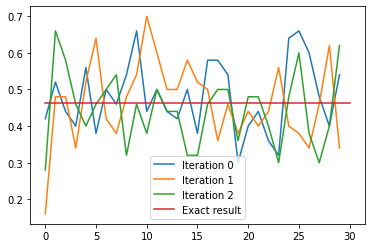

In [6]:
n = 30
L = 10

for i in range(3):
    lattice = Lattice(L = L, B = 0.5)
    solver = Solver(lattice)
    gen = solver.iterate()

    M = []
    for _ in range(n):
        for _ in range(L**2):
            lat = next(gen)
        
        M.append(lat.M)

    plt.plot(range(n), np.array(M)/100, label=f"Iteration {i}")

plt.plot((0, n), [np.tanh(0.5) for _ in range(2)], label=f"Exact result")
plt.legend()

#### 6b)

In 5b), we determined $\kappa \approx 200$. Relating that to the situation here, it would mean $\kappa \approx 2$. However, as we can deduce from the plot, it is near impossible to determine when the tail of the convergence ends and the oscillating behaviour around a mean starts. Therefore, we could say that the equilibration time is zero. The system is in equilibrium from the word go. 

#### 6c)

In [7]:
n = 30
L = 10
iter = 100

lattice = Lattice(L = L, B = 0.5)
solver = Solver(lattice)
gen = solver.iterate()

exp_m = []
exp_m2 = []

for _ in range(iter):
    M = []
    for _ in range(n):
        for _ in range(L**2):
            lat = next(gen)

        M.append(lat.M)
        
    m = np.array(M) / L**2
    exp_m.append(1/len(M) * np.sum(m))
    exp_m2.append(1/len(m) * np.sum(m**2))
    
exp_m = np.array(exp_m)
exp_m2 = np.array(exp_m2)

dm = np.sqrt((m2 - exp**2)/(len(m)-1))

print(f"   Exact: m = {np.tanh(0.5)}")
print(f"Computed: m = {np.mean(exp)} ± {np.std(exp)} (standard deviation)")
print(f"Computed: m = {np.mean(exp)} ± {np.mean(dm)} (delta m over average M)")

   Exact: m = 0.46211715726000974
Computed: m = 0.46275011111111114 ± 0.024855925914640028 (standard deviation)
Computed: m = 0.46275011111111114 ± 0.015477165013752268 (delta m over average M)


From the results of the script we can easily see that the error on the magnetisation per site $\Delta_m$ now is a much more reasonable error. It is smaller than the standard deviation, but still large enough that it encompasses the exact value within its bounds. I find it interesting to see that this switch to only storing every $L^2$'th point ensures that $\Delta_m$ is suddenly a reasonable error estimate. I presume the influence of $N_{MC}$ in $\Delta_m$, which now is a much smaller value, ensures that the error doesn't get too small to quickly.

#### 7)
The relevant script and plot are found below. The computed values closely follow the exact result.

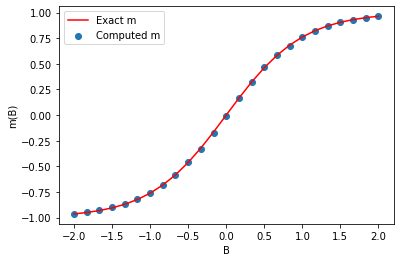

In [8]:
L = 10
iter = 1000
B = np.linspace(-2, 2, 25)
solver = Solver(None)
m = []
res = []

for b in B:
    solver.lattice = Lattice(L = L, B = b)
    tmp = solver.fullsolve(iter, ("<m>", "chi"))
    res.append(tmp)
    m.append(tmp["<m>"])
    
plt.scatter(B, m, label="Computed m")
plt.plot(B, np.tanh(B), label="Exact m", color="r")
plt.xlabel("B")
plt.ylabel("m(B)")
plt.legend()

#### 8a)

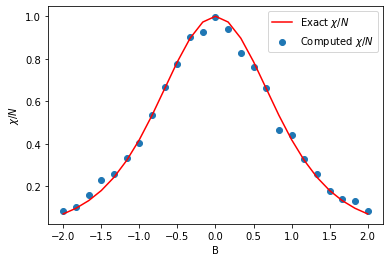

In [9]:
plt.scatter(B, [i["chi"]/L**2 for i in res], label=r"Computed $\chi / N$")
plt.plot(B, 1/np.cosh(B)**2, label=r"Exact $\chi / N$", color="r")
plt.xlabel("B")
plt.ylabel(r"$\chi / N$")
plt.legend()

What we can see from the plot when $N_{MC} = 40$, is that the computed fluctuations follow the rough shape of th exact fluctuations. However, there is quite a large error in the computed values, especially near the edges of the plot, thus for large $| B |$. Increasing $N_{MC}$ to large values, for example $1000$, the computed value follows the exact value much more closely. This however comes at the disadvantage that the computation time increases dramatically. 

(Note: the computation time with $N_{MC} = 1000$ even longer for 8b, since this is done 100 times. To ensure that I keep my sanity, I will restrict $N_{MC}$ such that the execution time is not too large. This will mean that results are less accurate.)

#### 8b)
Given that for $\chi$, the following also holds:
$$
\chi = \frac{d\langle M\rangle}{dB},
$$
we can compute $\chi$ as small deviations from a fixed value.

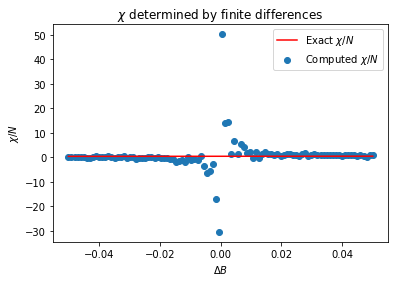

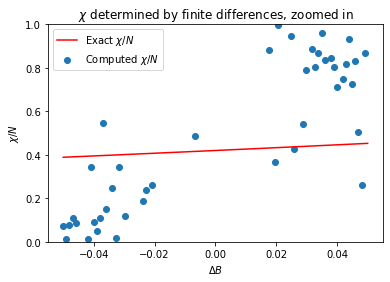

In [10]:
B = 1
iter = 100
exp_M = Solver(Lattice(L = L, B = B)).fullsolve(iter, ("<M>"))["<M>"]
chi = []

B_iter = np.linspace(0.95, 1.05, 100)
for b in B_iter:
    dB = b - B
    e_M = Solver(Lattice(L = L, B = b)).fullsolve(iter, ("<M>"))["<M>"]
    dM = e_M - exp_M
    
    chi.append(dM / dB)

plt.scatter(B - B_iter, np.array(chi)/L**2, label=r"Computed $\chi / N$")
plt.plot(B - B_iter, 1/np.cosh(B_iter)**2, label=r"Exact $\chi / N$", color="r")
plt.xlabel(r"$\Delta B$")
plt.ylabel(r"$\chi / N$")
plt.title(r"$\chi$ determined by finite differences")
plt.legend()

plt.figure()
plt.scatter(B - B_iter, np.array(chi)/L**2, label=r"Computed $\chi / N$")
plt.plot(B - B_iter, 1/np.cosh(B_iter)**2, label=r"Exact $\chi / N$", color="r")
plt.ylim(0, 1)
plt.xlabel(r"$\Delta B$")
plt.ylabel(r"$\chi / N$")
plt.title(r"$\chi$ determined by finite differences, zoomed in")
plt.legend()

At small differences ($\Delta B \approx 0$), $\chi$ displays an asymptotic behavior (due to the near division by zero). This regime is not very useful.

At slightly larger displacements, the obtained values for $\chi$ are in the expected order of magnitude. Obtaining the correct value however doesn't seem feasible using this method. With $\Delta B > 0$, the computed values of $\chi$ are above the exact values. For $\Delta B < 0$ the computed values are smaller than the exact values. If we take the mean of these two regimes and ignoring $\Delta B \approx 0$ we "might" obtain a reasonable value for $\chi$. I feel however, that this is not very accurate.

Taking $\Delta B$ >> 0, we seem to converge to the exact value. The mathematical accuracy of this can be disputed, but physically speaking this approach would seem sound.

## Part 2

#### 1)
In 4a) of Part 1, we described a way for computing the energy after a spin was flipped based only upon the energy before the flip and a constant. This allowed us to calculate the energy without remembering all the states that came before it. Unfortunately, in 4a) of Part 1, we limited ourselves to the case where $J = 0$. Let us now expand the expression for the energy change to encompass cases where $J \neq 0$.

Starting with the change in energy when flipping a spin, based on eq. 31 from the lecture notes,
\begin{aligned}
    \Delta E = E(S') - E(S) &= -J \sum\sum s_i's_j' + J \sum\sum s_is_j + \Delta E_B \\
    &= J\left(\sum\sum s_is_j - \sum\sum s_i's_j'\right) + \Delta E_B.
\end{aligned}

Given that we are only flipping one spin, most of the sums cancel out  each other. In other words, only the spin that flips and its neighbours need to be recalculated. Let us call the spin that flips $s_f$. We get

\begin{aligned}
    \Delta E &= J\left(\sum s_fs_j - \sum s_f's_j'\right) + \Delta E_B\\
    &= J\left(s_f\sum s_j - s_f'\sum s_j'\right) + \Delta E_B.
\end{aligned}

Now, since we only flip spin $s_f$, $\sum s_j = \sum s_j'$. We can then take this expression outside the brackets. Evaluating remaining expression in brackets,

\begin{equation}
    (s_f - s_f') = 
    \begin{cases}
        2 & \text{for spin up to spin down} \\
        -2 & \text{for spin down to spin up}
    \end{cases}.
\end{equation}

Combining this with the latest expression for $\Delta E$, we finally obtain

\begin{equation}
    \Delta E = s_f\left(2J\sum s_j + 2B\right),
\end{equation}

where $s_f$ is the spin to flip, and $\sum s_j$ is the sum of $s_f$'s nearest neighbour spins. The expression for the magnetic field part is slightly different from that of Part 1, due to the inclusion of the spin to flip for the current state. Mathematically the expressions are identical.

#### 2a)

In 50 runs, spin up was observed 27x (54.0%), spin down 23x


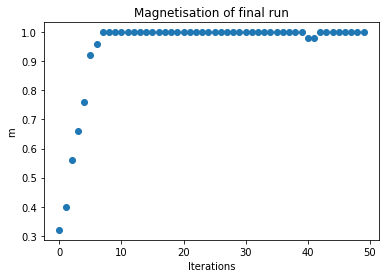

In [11]:
L = 10
J = 1
B = 0
beta = 1
iterations = 50

runs = 50
align = [0, 0]

for _ in range(runs):
    lattice = Lattice(L = L, B = B, J = J, beta = beta)
    solver = Solver(lattice)

    m = solver.fullsolve(iterations, ("m"))["m"]
    if np.mean(m) > 0:
        align[0] += 1
    else:
        align[1] += 1

plt.scatter(range(iterations), m)
plt.xlabel("Iterations")
plt.ylabel("m")
plt.title("Magnetisation of final run")

print(f"In {runs} runs, spin up was observed {align[0]}x ({100 * align[0] / np.sum(align)}%), spin down {align[1]}x")

When repeating the run multiple times one thing becomes obvious. Either all the spins align up, or all spins align down. This is to be expected, given that $J > 0$. In this case the system is a ferromagnet.

On average, there is a 50/50 chance of the final state being either spin up or spin down.

On average, saying that the equilibrium time $\kappa$ does not exceed 20 iterations is reasonable.

Without a magnetic field, given infinite runs, we would obtain a system with all spin ups 50% of the time, and a system with all spin downs 50% of the time. This respectively gives $1$ and $-1$ for $\langle m\rangle$. Taking the mean of this then, gives a total expectation value $\langle m \rangle = 0$

#### 2b)

The same code as in 2a) will be used, but now with an additional iteration for $B = 1$ and $B = 0,05$

In 50 runs for B = 1, spin up was observed 50x (100.0%), spin down 0x
In 50 runs for B = 0.05, spin up was observed 30x (60.0%), spin down 20x


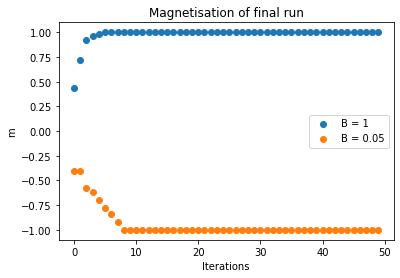

In [12]:
B = (1, 0.05)

align = [[0,0],[0,0]]

for index, b in enumerate(B):
    for _ in range(runs):
        lattice = Lattice(L = L, B = b, J = J, beta = beta)
        solver = Solver(lattice)

        m = solver.fullsolve(iterations, ("m"))["m"]
        if np.mean(m) > 0:
            align[index][0] += 1
        else:
            align[index][1] += 1

    plt.scatter(range(iterations), m, label=f"B = {b}")
    print(f"In {runs} runs for B = {b}, spin up was observed {align[index][0]}x ({100 * align[index][0] / np.sum(align[index])}%), spin down {align[index][1]}x")
    
plt.xlabel("Iterations")
plt.ylabel("m")
plt.title("Magnetisation of final run")
plt.legend()

In the case where $B = 0,05$, there is an increase in the amount of times a spin up configuration was observed. The amount of spin ups observed is already significantly higher with this slight bias compared to the unbiased $B=0$ case.

In the case where $B=1$, a spin up system is pretty much guaranteed. This is as expected. The magnetic field provides a bias for all the individual spins, such that they are much more likely to align in the same direction as the magnetic field. The stronger the magnetic field, the more likely the spins will align with the magnetic field.

#### 2c)

The same code as 2a) will be used.

In 50 runs, the mean of <m> > 0 25x (50.0%), <m> <= 0 25x


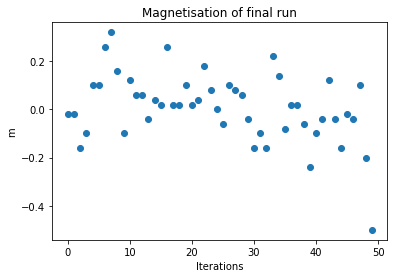

In [13]:
B = 0
beta = 0.2

align = [0, 0]

for _ in range(runs):
    lattice = Lattice(L = L, B = B, J = J, beta = beta)
    solver = Solver(lattice)

    m = solver.fullsolve(iterations, ("m"))["m"]
    if np.mean(m) > 0:
        align[0] += 1
    else:
        align[1] += 1

plt.scatter(range(iterations), m)
plt.xlabel("Iterations")
plt.ylabel("m")
plt.title("Magnetisation of final run")

print(f"In {runs} runs, the mean of <m> > 0 {align[0]}x ({100 * align[0] / np.sum(align)}%), <m> <= 0 {align[1]}x")

$\beta$ influences the probability of accepting the suggested move. A smaller beta decreases the probability ($P \sim e^{-\beta}$) of accepting the move. We thus see a spread where the magnetisation per site does not converge to a specific value. Even with $N_{MC} = 1000$ there still does not seem to be a convergence to a determined value of m. We could thus say that $\kappa \rightarrow \inf$, since the run will never converge. On the other hand, we could say that $\kappa = 0$, since there is no change in behaviour for an increased amount of iterations. Either way, $\langle m \rangle \approx 0$, and $m \in [-0,5; 0,5]$.

From its definition, we have
\begin{equation}
    \beta = \frac{1}{k_B T}.
\end{equation}

Combining this with the phase diagram found in the figure below, we can tell something about the symmetry breaking. For $\beta = 0,2$, $T > T_c$ and thus we have symmetry. What we can see from our simulation results, and confirm using this figure, is that the average magnetisation per site is 0. For $\beta = 1, T < T_c$, and hence we are in a state where symmetry is broken. This is again confirmed by previous experiments, where the average magnetisation per site was either 1 or -1.


#### 3a)

Text(0, 0.5, '<m>')

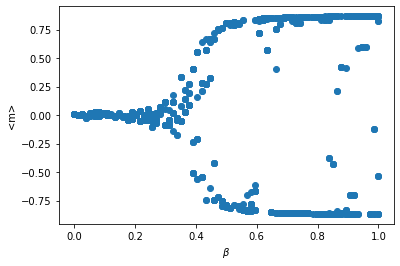

In [14]:
L = 10
B = 0
runs = 15
iterations = 150

beta = np.repeat(np.linspace(0, 1, 75), runs)
        
def solve(beta):
    lattice = Lattice(L = L, B = B, J = J, beta = beta)
    solver = Solver(lattice)
    
    return solver.fullsolve(iterations, ("<m>", "chi"), kappa=20)
    
with ProcessPoolExecutor(8) as ex:
    res = ex.map(solve, beta)
    
res = list(res)

m = [i["<m>"] for i in res]
        
plt.scatter(beta, m)
plt.xlabel(r"$\beta$")
plt.ylabel("<m>")

The resulting figure shares a striking resemblence to the temperature phase diagram found above in 2c). The critical point, $\beta_c \approx 0,4$, defines the point where the physics of the system changes. For $\beta < \beta_c$, the system still has symmetry. When we increase $\beta > \beta_c$, the system goes through symmetry breaking, and we get a defined magnetisation of the lattice. Around the critical temperature there is a transition from symmetry to no symmetry. This behaviour seems to be rather sudden, like we would theoretically expect without the presence of a magnetic field. Due to the way the simulation is calculated, a complete sudden change will never be observed.

#### 3b)

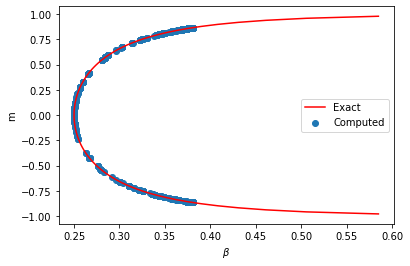

In [15]:
m = np.array(m)
m_exact = np.linspace(-1, 1, 100)

jb = 1/(8*m)*np.log((1+m) / (1-m))
jb_exact = 1/(8*m_exact)*np.log((1+m_exact) / (1-m_exact))

plt.scatter(jb / J, m, label="Computed")
plt.plot(jb_exact / J, m_exact, color="r", label="Exact")
plt.xlabel(r"$\beta$")
plt.ylabel("m")
plt.legend()

From the figure we can see that the theory and computed values line up quite nicely. We can say that the theory holds up, with the assumption that our model is valid, correct and accurate enough.

#### 3c)

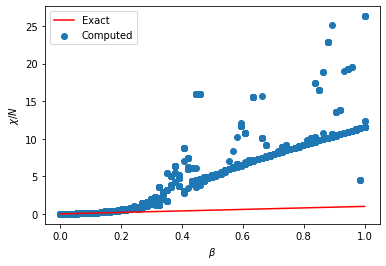

In [16]:
chi = np.array([i["chi"] for i in res])

plt.scatter(beta, chi / L**2, label="Computed")
plt.plot(beta, beta / np.cosh(beta * B)**2, label="Exact", color="r")
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\chi / N$")
plt.legend()

Around the critical point we can see that the computed value of $\chi$ start deviating quite dramatically from the exact value. Around this point there also seems to be some more scattering than elsewhere.

## Part 3

#### 1a)

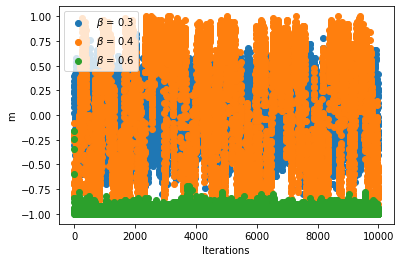

In [17]:
L = 10
B = 0
J = 1
beta = (0.3, 0.4, 0.6)
iter = int(1E4)

def solve_beta(beta):
    lattice = Lattice(L = L, B = B, J = J, beta = beta)
    solver = Solver(lattice)
    
    return solver.fullsolve(iter, ("m"))["m"]

with ProcessPoolExecutor(8) as ex:
    res = ex.map(solve_beta, beta)
    
res = list(res)

for index, r in enumerate(res):
    plt.scatter(range(iter), r, label=rf"$\beta$ = {beta[index]}")

plt.xlabel("Iterations")
plt.ylabel("m")
plt.legend()

Comparing these three betas, we can see that with increasing $\beta$ the system becomes more stable. A magnetisation is chosen, and less likely to change with increasing $\beta$. Around the critical point we can see the magnetisation of the system changing quite a bit. At lower $\beta$ the system is moving between m = +1 and m = -1, but never quite reaching these fully magnetised states. Pushing $\beta$ even lower would mean that there is no clear definition of "switching between two magnetisations". At that point the average magnetisation per site reduces to zero.

#### 1b)

The sketch can be found below. For $\beta = 0,6$, the probability is highest that m is either 1 or -1. As $\beta$ decreases, the probability around the boundaries decrease and the probability around $m = 0$ increases.

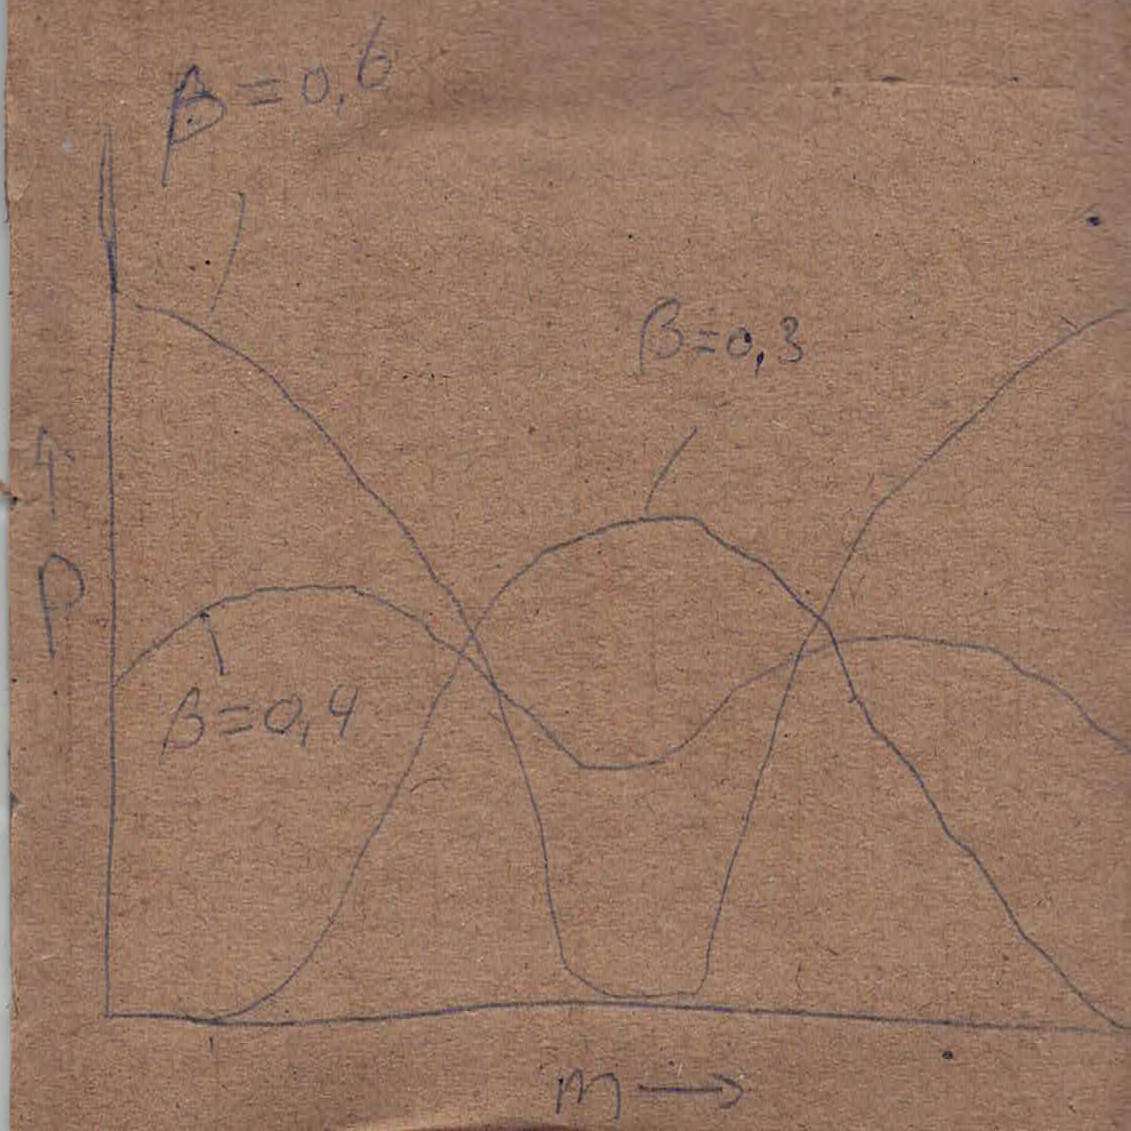

#### 2a)

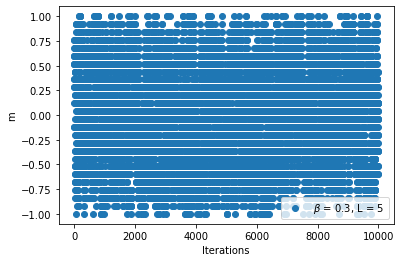

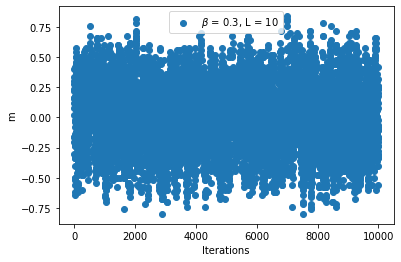

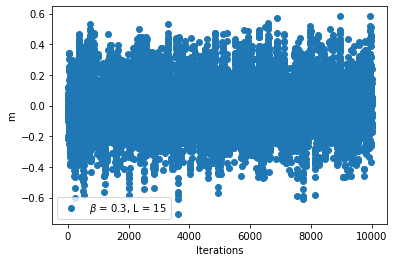

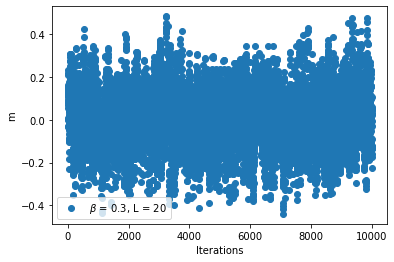

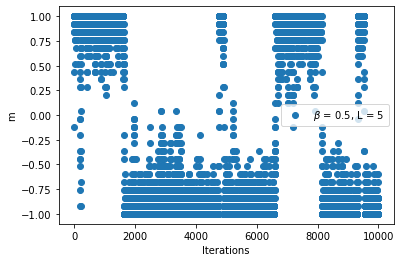

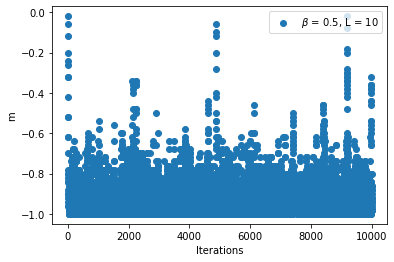

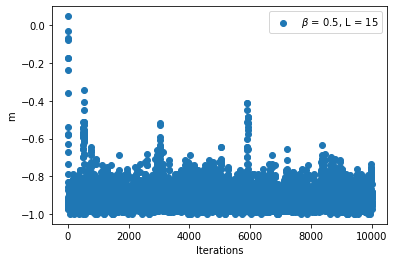

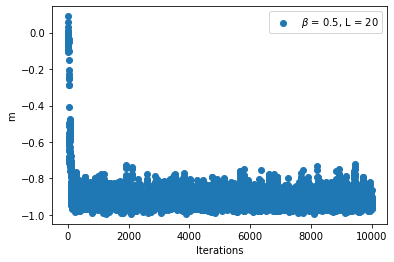

In [18]:
iterable = ((0.3, 5), (0.3, 10), (0.3, 15), (0.3, 20), \
           (0.5, 5), (0.5, 10), (0.5, 15), (0.5, 20))

def solve(items):
    lattice = Lattice(L = items[1], B = B, J = J, beta = items[0])
    solver = Solver(lattice)
    
    return {
        "m": solver.fullsolve(iter, ("m"))["m"],
        "L": items[1],
        "beta": items[0]
    }

with ProcessPoolExecutor(8) as ex:
    res = ex.map(solve, iterable)
    
res = list(res)

for r in res:
    plt.figure()
    plt.scatter(range(iter), r["m"], label=rf"$\beta$ = {r['beta']}, L = {r['L']}")
    plt.xlabel("Iterations")
    plt.ylabel("m")
    plt.legend()


In both instances, we can see that when the lattice grows, the resolution (at i.e. the magnetisation boundaries) increases. This makes sense, as when there are more sites, a single spin flip influences the average magnetisation per site less. In the case where $\beta = 0,3$ though, it does seem that a larger grid ensures more states where the average magnetisation isn't fully up or fully down. Since there are more sites to flip, it takes a longer amount to reach either +1 or -1. In this time then, the probability of the system reverting its path is just as large as the system continuing on. This gives the expected $\langle m \rangle \approx 0$ with deviations around this mean. These deviations decrease with increasing lattice sizes.

For $\beta = 0,5$, we see that an increase in the lattice size ensures less changes of total magnetisation over time. This again has to do with more sites meaning less influence per site. In the case where $L=5$ for example, a few flips of individual sites around each other can tip the balance from positive to negative magnetisation. As the amount of sites increase, this is less and less likely to happen.

As for the probability then. For $\beta = 0,3$ and increasing L, the probability around the edges +1 and -1 will decrease and the probability around $m = 0$ will increase.
For $\beta = 0,5$ and increasing L, the probability around the edges +1 and -1 will only increase further, and the probability everywhere else will diminish towards zero.

#### 2b)

As long as $\beta > \beta_c$, I feel that symmetry breaking will become more appearant as L increases. This is most likely due to the effects of a single spin change becoming less and less effective and noticable on the whole system. In this way, when $L \rightarrow \inf$, it will be impossible for the system to deviate much from its either +1 or -1 state of average magnetisation per site.

#### 3a)

Text(0, 0.5, '<E> / N')

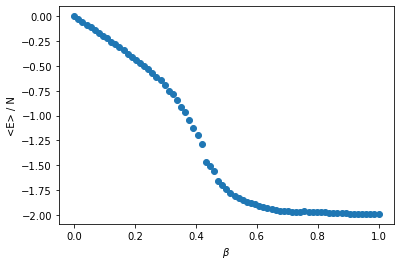

In [19]:
L = 10
B = 0
beta = np.linspace(0, 1, 75)
iter = 2000

def solve(beta):
    lattice = Lattice(L = L, B = B, J = J, beta = beta)
    solver = Solver(lattice)
    
    return solver.fullsolve(iter, ("<e>"))["<e>"]
    
with ProcessPoolExecutor(8) as ex:
    res = ex.map(solve, beta)
    
res = list(res)

plt.scatter(beta, res)
plt.xlabel(r"$\beta$")
plt.ylabel("<E> / N")

In our case, we can simplify the expression for $E$ as follows,

\begin{equation}
    E(S) = -\frac{1}{2}\sum\sum s_is_j.
\end{equation}

From this equation, the behaviour of the plot above is explained quite clearly. After the critical point $\beta_c$, the system will become magnetised such that $\langle m \rangle = +1 \vee -1$. This means that per site, the energy will consist of a sum of $(-1 \cdot -1)$'s or $(+1 \cdot +1)$'s. Summing either results in $4$, which multiplied by $-0,5$ ensures that $E(S) = -2$.

When $\beta \leq \beta_c$, it becomes far more likely to have an equal amount of neighbours with the same spin and opposite spin per site. On average, per site we will get two $(-1 \cdot -1)$'s or $(+1 \cdot +1)$'s and two $(+1 \cdot -1)$'s or $(-1 \cdot +1)$'s, which sum to zero.

Between these two extremes then, there exists a balancing act of thermodynamic effects. Around the critical point we can see the sudden shift caused by symmetry breaking, where a defined magnetisation becomes more energetically favourable.

#### 3b)

Following the exact same steps as Part 1, 1b), we get

\begin{aligned}
    \frac{\partial \langle E \rangle}{\partial T} &= \frac{\partial}{\partial T} \left(\frac{1}{Z}\right) \sum Ee^{-\beta E} + \frac{1}{Z} \frac{\partial}{\partial T} \sum Ee^{-\beta E} \\
    &= E * \frac{\partial \beta}{\partial T} \frac{1}{Z^2} \sum Ee^{-\beta E} e^{-\beta E} - \frac{1}{Z} \sum Ee^{-\beta E} E \frac{\partial \beta}{\partial T},
\end{aligned}

where 

\begin{equation}
    \beta = \frac{1}{k_B T}, \\
    \frac{\partial \beta}{\partial T} = - \frac{1}{k_B T^2} = -k_B \beta^2.
\end{equation}

Combining the equations, we obtain

\begin{aligned}
    \frac{\partial \langle E \rangle}{\partial T} &= \frac{1}{Z}\sum E^2 e^{-\beta E} \cdot k_B \beta^2 - \frac{1}{Z^2}\sum E^2 e^{-2\beta E} \cdot k_B \beta^2 \\
    &= k_B \beta^2 \left( \langle E^2 \rangle - \langle E \rangle^2 \right),
\end{aligned}

as expected.

#### 3c)

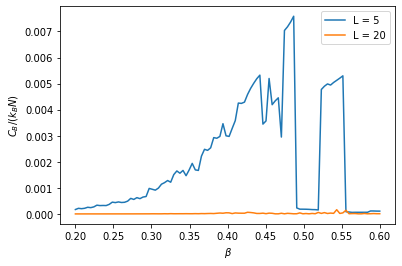

In [22]:
L = (5, 20)
beta = np.linspace(0.2, 0.6, 100)
iter = 500

perm = itertools.product(L, beta)

def solve(items):
    lattice = Lattice(L = items[0], B = B, J = J, beta = items[1])
    solver = Solver(lattice)
    
    return {
        "Cb": solver.fullsolve(iter, ("Cb"))["Cb"],
        "L": items[0]
    }
    
with ProcessPoolExecutor(8) as ex:
    res = ex.map(solve, perm)
    
res = list(res)

for l in L:
    plt.plot(beta, [i["Cb"] / i["L"]**2 for i in res if i["L"] == l], label=f"L = {l}")
    
plt.xlabel(r"$\beta$")
plt.ylabel(r"$C_B / (k_BN)$")
plt.legend()

This result doesn't make sense what so ever.